# **A nearly-constant velocity example**
Simple scenario in which a target moves at constant velocity with the addition of some random noise (referred to as *nearly constant* velocity model). 

We will assume that all the measurements come from the real objective. And the detection is perfect: 
* Detection probability $p_d=1$
* False alarm probability $p_{fa}= 0$

In [3]:
import numpy as np 
from datetime import datetime, timedelta

## Simulate a target

2d cartesian scheme where the state vector is $[x, y, vx, vy]^T $. We model the target motion as a position and velocity component in each dimension. The units used are unimportant, but we need consistency.

First, we crate simple truth path, sampling 1 second intervals. 

In [4]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity

# start the clock
start_time = datetime.now()

Useful to fix random number generator in order to probe a particular example repeatedly.

In [5]:
np.random.seed(1313)

Using the `ConstantVelocity` class to create a one-dimensional constant velocity model with Gaussian noise, and `CombinedLinearGaussianTransitionModel`

In [ ]:
q_x = 0.05  # velocity in x
q_y = 0.05  # velocity in y 
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q_x),
                                                          ConstantVelocity(q_y)])

A truth path is created starting at (0,0) moving to the NE at one distance unit per (time) step in each dimension

In [ ]:
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])

# 20 steps simulation
num_steps = 20

# for each step we will calculate the state
for k in range(1, num_steps + 1):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))

We will import a Plotter from the Stonesoup library. The mapping argument will be [0,2] since those are the x and y position indices from our state vector.

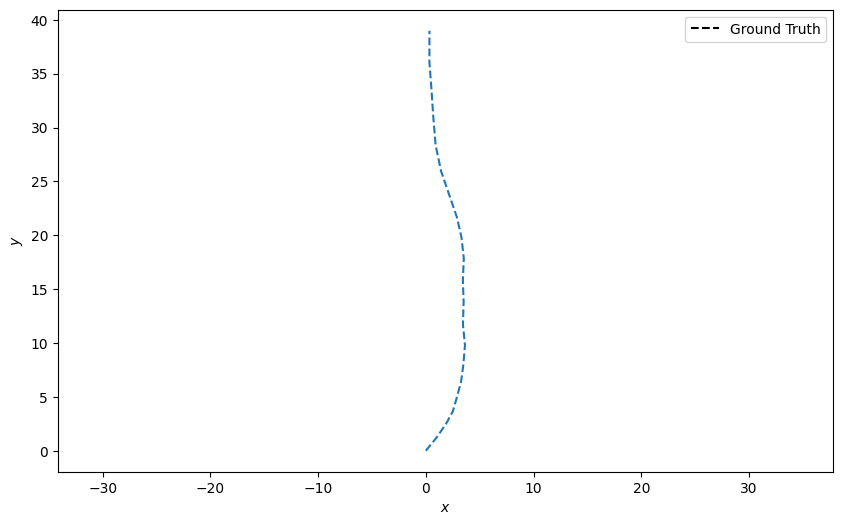

In [8]:
from stonesoup.plotter import Plotter

# create a Plotter instance
plotter = Plotter()
plotter.plot_ground_truths(truth, [0,2])

Check the Fk and Qk matrices (generated over 1s period)

In [9]:
transition_model.matrix(time_interval=timedelta(seconds=1))

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [10]:
transition_model.covar(time_interval=timedelta(seconds=1))

array([[0.01666667, 0.025     , 0.        , 0.        ],
       [0.025     , 0.05      , 0.        , 0.        ],
       [0.        , 0.        , 0.01666667, 0.025     ],
       [0.        , 0.        , 0.025     , 0.05      ]])

## Simulate measurements

Now we will play with various parameters and see how it affects the simulated output. We will use some Stone Soup's measurement models to generate measurements from the ground truth. 

We will asume a 'linear' sensor which detects the position, but not velocity, of a target. 

$z_k = H_kx_k + v_k, \space v_k \approx N(0,R)$

In the matrix R, w is set to 5 initially.

We eill need a detection type to store the detection, and a LinearGaussian measurement model. 

In [11]:
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian

A linear Gaussian measurement model is set up by indicating the number of dimensions in the state vector and the dimensions that are measured (so specifying Hk) and the noise covariance matrix R. 

In [20]:
measurement_model = LinearGaussian(
    ndim_state=4,   # number of state dimensions (position and velocity in 2d)
    mapping=(0,2),   # mapping measurement vector index to state index
    noise_covar=np.array([
        [2,0], 
        [0,2]
    ])
)

# Check the output is as we expect
measurement_model.matrix()

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [21]:
measurement_model.covar()

CovarianceMatrix([[2, 0],
                  [0, 2]])

Now we generate the measurements:

In [22]:
measurements = []
for state in truth: 
    measurement = measurement_model.function(state, noise=True)
    measurements.append(
        Detection(
            measurement,
            timestamp=state.timestamp, 
            measurement_model=measurement_model
        )
    )

Plot the results, again mapping the x and y position values.

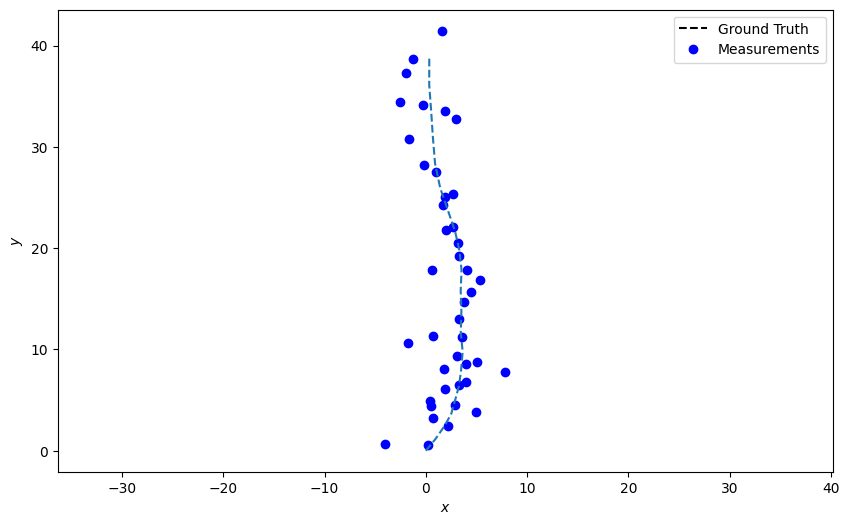

In [23]:
plotter.plot_measurements(measurements, [0,2])
plotter.fig

Now we have a moderately linear ground truth + series of simulated measurements overplotted.

## Construct a Kalman Filter

We will use a simple Kalman Filter, that consists of two main steps: 
* Prediction 
* Update

Constructing a filter in Stone Soup is simple: 
* Predictor takes a TransitionModel as input
* Updater takes a MeasurementModel as input

Now we will be using the same models used to generate the ground truth and the simulated measurements. This WON'T USUALLY BE POSSIBLE and it's an interesting exercise to explore what happens when these parameters are mismatched.

In [24]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

## Run the Kalman Filter

We're going to use the `GaussianState`. By happy chance initial values are chosen to match the truth quite well, but we can manipulate these to see what happens.

In [25]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

Stone Soup requires that a Predictor and Detection are associated explicitly. This is done by way of a `Hypothesis`; the most simple is a `SimpleHypothesis`, which associates a single predicted state with a single detection. 

In [26]:
from stonesoup.types.hypothesis import SingleHypothesis

Now we will loop through out measurements, predicting and updating at each timestep. Storing the information is facilitated by the top-level `Track` class, which holds a sequence of states.

In [28]:
from stonesoup.types.track import Track
# initialize a track
track = Track()

# for each measurement
for measurement in measurements:
    # we predict in the new time
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    # we generate a hypothesis
    hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
    # we update 
    post = updater.update(hypothesis)
    # we add the state to the track
    track.append(post)
    prior = track[-1]

Plot the resulting track, including uncertainty ellipses.

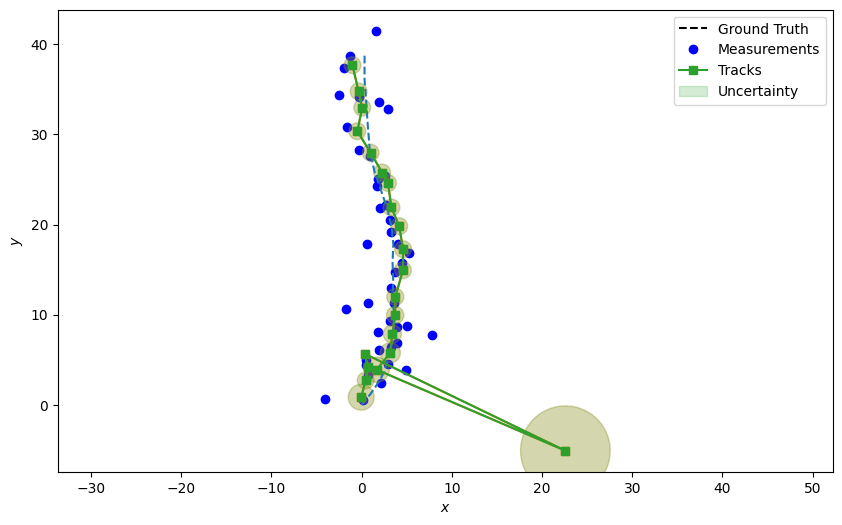

In [30]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig